In this script we test the most significant nodes for each variable in the Nearest Neighbours and Anna K models. We chose the ten most significant nodes (which we significant prior to MCC). We wanted to investigate whether they remain significant using a more controlled amount of comparisons (which they should), and whether they yield a different correlation (which they should not).

In [1]:
# importing packages

# general
import os

# for data wrangling/management and non-MRI calculations 
import numpy as np
import pandas as pd
import scipy
from scipy.stats import rankdata, ttest_rel, ttest_1samp
import statsmodels.stats.multitest
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

# for plotting
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# for fMRI
import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf
from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold
from nltools import Brain_Data

#import glob
#import datalad.api as dl
#from pathlib import Path
#import seaborn as sns
#from datetime import datetime

%matplotlib inline

# setting work and data directories
csv_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/csv_data/") # this on the server
fmri_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/fmri_data/") # this on the server

# loading data
confirmatory_data = pd.read_csv(str(csv_directory + "/confirmatory_half.csv"), sep = ',')
confirmatory_data.head()

/home/c13572687/anaconda3/envs/isrsa/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/c13572687/anaconda3/envs/isrsa/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


,participant_id,age,sex,education_level,background_SES,social.ideology,social.ideology.scale,social.identity,social.identity.scale,political.interest,political.interest.scale
0,sub-0004,22.50,female,high,5.0,2.00,0.497680,3,-0.240663,NaN,NaN
1,sub-0006,24.75,female,medium,2.5,1.50,-0.338874,2,-1.011424,NaN,NaN
2,sub-0008,20.50,female,medium,2.0,1.00,-1.175427,2,-1.011424,NaN,NaN
3,sub-0011,25.25,male,medium,3.0,1.75,0.079403,3,-0.240663,NaN,NaN
4,sub-0014,21.50,male,high,4.0,1.00,-1.175427,3,-0.240663,NaN,NaN


Loading in Shen mask:

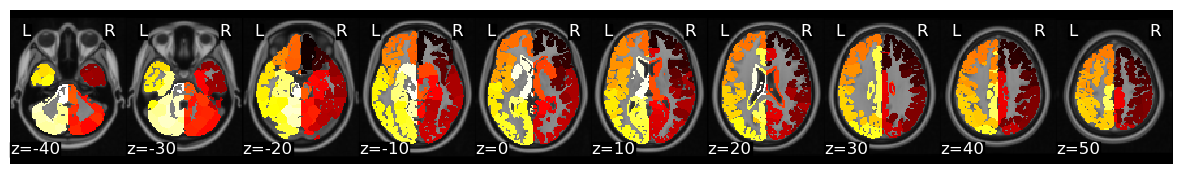

In [2]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=False)

We need to load in the data, then per-subject per-run we need to resample and apply the mask, then create a node-wise time series. In the following cell we create a function which does this, and in the cell after we run it for 20 subjects simulatenously.

In [ ]:
subj_list = np.arange(0, len(confirmatory_data['participant_id']),1)

def get_ts(subject):
    for run in [1, 2, 3]:
        this_subject = confirmatory_data['participant_id'][subject]
        fmri_filename = os.path.join(fmri_directory, confirmatory_data['participant_id'][subject], 'func', str(confirmatory_data['participant_id'][subject] + '_task-moviewatching_bold.nii.gz'))
        print(f"Creating node time series for {this_subject}, run {run}")
        
        # we need to resample first, then apply the mask
        brain_data = Brain_Data(fmri_filename)
        time_series_fname = os.path.join(fmri_directory, this_subject, 'func', str(f'{this_subject}_run-{run}_nodeTimeSeries.csv'))
        time_series = masker.fit_transform(brain_data.to_nifti())
        pd.DataFrame(time_series).to_csv(time_series_fname, index=False)
    return

Parallel(n_jobs=20)(delayed(get_ts)(subject) for (subject) in subj_list)

We now have to add all runs from all subjects into a `numpy` array:

In [4]:
subj_list = np.arange(0,len(confirmatory_data['participant_id']),1)
data = []
for subj in tqdm(subj_list):
    this_subject = confirmatory_data['participant_id'][subj]
    sub_data = []
    for run in range(1,4):
        current_file = pd.read_csv(os.path.join(fmri_directory, this_subject, 'func', str(f'{this_subject}_run-{run}_nodeTimeSeries.csv')))
        sub_data.append(current_file)
    sub_data = pd.concat(sub_data)
    data.append(sub_data.values)

data = np.array(data)

100%|█████████████████████████████████████████| 427/427 [00:52<00:00,  8.10it/s]


We should check that we have the correct data structure, which is number of subjects x number of time points across all 3 runs x number of nodes. For our data this should be 427 x 870 x 268.

In [5]:
print(data.shape)
n_subs, n_ts, n_nodes = data.shape

(427, 870, 268)


We will now visualize our similarity matrix and see that it makes sense (i.e., that there are different colours which indicate different correlations between subjects for a particular node):

In [6]:
similarity_matrices = []
for node in range(n_nodes):
    similarity_matrices.append(Adjacency(1 - pairwise_distances(data[:, :, node], metric='correlation'), matrix_type='distance'))
similarity_matrices = Adjacency(similarity_matrices)

#saving_directory = os.path.dirname("/home/c13572687/Documents/scripts_and_data/figures/")

#random_nodes = np.random.randint(0, 267, 3)
#for node in random_nodes:
#    plt.figure()
#    similarity_matrices[node].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')    
#    plt.title(str("Visualizing similarity matrix for node " + str(node)))
#    plt.savefig(os.path.join(saving_directory + '/confirmatory/RDMs/confirmatory-RDM-node_' + str(node) + '.png'), dpi = 500)
#    plt.show()

Next, we calculate and plot the intersubject synchrony of each of our 268 nodes (where a darker colour indicates a higher synchrony).
Sanity check: early cortical areas (such as the early visual and auditory cortexes) appear to be more synchronous!

In [ ]:
isc = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['isc'] for node in range(n_nodes)}
expand_mask(mask)
isc_brain = roi_to_brain(pd.Series(isc), expand_mask(mask))
plot_glass_brain(isc_brain.to_nifti(), cmap = 'RdBu_r', colorbar = True, title = "Confirmatory Univariate ISC")

#plt.savefig(os.path.join(saving_directory + '/confirmatory/brains/confirmatory_synchrony.png'), dpi = 500)
plt.show()

Now we'll load our behavioural data and produce RDMs using the Euclidean distance, firstly in a nearest neighbor (NN) model, then in an Anna-K (AK), then a Mahalanobis Distance (MD) model.

In [10]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

behav_sims_nn = dict()
for variable in variables:
    behav = confirmatory_data[variable][subj_list]
    behav_rank = rankdata(behav) # explicity convert the raw scores to ranks

    behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
    behav_sim_nn.distance_to_similarity()
    
    behav_sims_nn[variable] = behav_sim_nn.distance_to_similarity()

    #plt.figure()
    #behav_sim_nn.plot()
    #plt.title(str("Behavioral similarity matrix (NN) \n " + variable), fontsize=12)
    #plt.savefig(os.path.join(saving_directory + '/RDMs/new/confirmatory-RDM-NN-' + variable + '.png'), dpi = 500)


In [11]:
behav_sims_annak = dict() # creating dictionary to store matrices

for variable in variables:
    
    behav = confirmatory_data[variable][subj_list]
    behav_rank = rankdata(behav) # explicity convert the raw scores to ranks
    
    behav_sim_annak = np.zeros((n_subs, n_subs))

    # calculating Anna-K distance
    for i in range(n_subs):
        for j in range(n_subs):
            if i < j:
                sim_ij = np.mean([behav_rank[i], behav_rank[j]])/n_subs
                behav_sim_annak[i,j] = sim_ij
                behav_sim_annak[j,i] = sim_ij
            elif i==j:
                behav_sim_annak[i,j] = 1

    # plotting and saving in dict
    behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='distance')
    behav_sims_annak[variable] = behav_sim_annak

    #plt.figure()
    #behav_sim_annak.plot()
    #plt.title(str("Behavioral similarity matrix (AK) \n " + variable), fontsize=12)
    #plt.savefig(os.path.join(saving_directory + '/RDMs/new/confirmatory-RDM-AK-' + variable + '.png'), dpi = 500)


Now for the IS-RSA:

In [13]:
isrsa_nn, isrsa_annak, isrsa_md = {}, {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

isrsa_nn_brain = roi_to_brain(pd.Series(isrsa_nn), expand_mask(mask))
isrsa_annak_brain = roi_to_brain(pd.Series(isrsa_annak), expand_mask(mask))

In [ ]:
# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax = np.max(np.abs([list(isrsa_nn.values()), 
                      list(isrsa_annak.values())
                     ]))
plt.figure()
plot_stat_map(isrsa_nn_brain.to_nifti(), display_mode='x', cut_coords=8, vmax=vmax, title = "NN", cmap='RdBu_r')
plt.savefig(os.path.join(saving_directory + '/confirmatory/brains/nn_model_comparison.png'), dpi = 500)

plt.figure()
plot_stat_map(isrsa_annak_brain.to_nifti(), display_mode='x', cut_coords=8, vmax=vmax, title = "AnnaK", cmap='RdBu_r')
plt.savefig(os.path.join(saving_directory + '/confirmatory/brains/annak_model_comparison.png'), dpi = 500)


Now onto hypothesis testing!

The next three cells loop over each of our five variables and compares the behavioural score RDM to the neural RDM by creating a null distribution through permuting 10,000 times (Mantel's test). We save the resulting data in one of four dictionaries, which are then saved as files for easy access without having to rerun the entire test. The difference between the dictionaries is whether the data being saved is correlation or _p_-value data, and whether it is nodewise or `nifti` data.

Each cell runs the data from a different distance metric: the first is NN, the second is AK and the third is CDM.

In [7]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

path = os.path.join("/home/c13572687/Documents/scripts_and_data/numpy_files_analysis/exploratory/")

most_sig_social_identity_nn = np.load(os.path.join(path, "most_sig_social_identity_nn.npy"), allow_pickle = True)
most_sig_social_ideology_nn = np.load(os.path.join(path,"most_sig_social_ideology_nn.npy"), allow_pickle = True)
most_sig_education_level_nn = np.load(os.path.join(path,"most_sig_education_level_nn.npy"), allow_pickle = True)
most_sig_background_SES_nn = np.load(os.path.join(path,"most_sig_background_SES_nn.npy"), allow_pickle = True)
most_sig_sex_nn = np.load(os.path.join(path,"most_sig_sex_nn.npy"), allow_pickle = True)
most_sig_nn = dict({variables[0] : most_sig_social_identity_nn, variables[1] : most_sig_social_ideology_nn,
                variables[2] : most_sig_education_level_nn, variables[3] : most_sig_background_SES_nn,
                variables[4] : most_sig_sex_nn})

most_sig_social_identity_annak = np.load(os.path.join(path, "most_sig_social_identity_annak.npy"), allow_pickle = True)
most_sig_social_ideology_annak = np.load(os.path.join(path,"most_sig_social_ideology_annak.npy"), allow_pickle = True)
most_sig_education_level_annak = np.load(os.path.join(path,"most_sig_education_level_annak.npy"), allow_pickle = True)
most_sig_background_SES_annak = np.load(os.path.join(path,"most_sig_background_SES_annak.npy"), allow_pickle = True)
most_sig_sex_annak = np.load(os.path.join(path,"most_sig_sex_annak.npy"), allow_pickle = True)
most_sig_annak = dict({variables[0] : most_sig_social_identity_annak, variables[1] : most_sig_social_ideology_annak,
                variables[2] : most_sig_education_level_annak, variables[3] : most_sig_background_SES_annak,
                variables[4] : most_sig_sex_annak})

In [ ]:
nifti_saving_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/")

isrsa_nn_r_dict_conf = dict()
isrsa_nn_r_brain_dict_conf = dict()
isrsa_nn_p_dict_conf = dict()
isrsa_nn_p_brain_dict_conf = dict()

for variable in variables:
    isrsa_nn_r, isrsa_nn_p = {}, {}
    for node in tqdm(range(len(similarity_matrices))):
        if node in most_sig[variable]:
            stats_nn = similarity_matrices[node].similarity(behav_sims_nn[variable], metric='spearman', n_permute=10000, n_jobs=-1 )
            isrsa_nn_r[node] = stats_nn['correlation']
            isrsa_nn_r_dict_conf[variable, node] = stats_nn['correlation']
            isrsa_nn_p[node] = stats_nn['p']
            isrsa_nn_p_dict_conf[variable, node] = stats_nn['p']
        else:
            isrsa_nn_r[node] = 0
            isrsa_nn_r_dict_conf[variable, node] = 0
            isrsa_nn_p[node] = 1
            isrsa_nn_p_dict_conf[variable, node] = 1
        
    isrsa_nn_r_brain = roi_to_brain(pd.Series(isrsa_nn_r), expand_mask(mask))
    isrsa_nn_p_brain = roi_to_brain(pd.Series(isrsa_nn_p), expand_mask(mask))

    isrsa_nn_r_brain_dict_conf[variable] = isrsa_nn_r_brain
    isrsa_nn_p_brain_dict_conf[variable] = isrsa_nn_p_brain
    
    file_name = str("isrsa_nn_r_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_r_brain_dict_conf[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    file_name = str("isrsa_nn_p_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_nn_p_brain_dict_conf[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    plot_stat_map(isrsa_nn_r_brain_dict_conf[variable].to_nifti(),
                 title = variable + ", NN")
    

In [ ]:
nifti_saving_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/")

isrsa_annak_r_dict_conf = dict()
isrsa_annak_r_brain_dict_conf = dict()
isrsa_annak_p_dict_conf = dict()
isrsa_annak_p_brain_dict_conf = dict()

for variable in variables:
    isrsa_annak_r, isrsa_annak_p = {}, {}
    for node in tqdm(range(len(similarity_matrices))):
        if node in most_sig[variable]:
            stats_annak = similarity_matrices[node].similarity(behav_sims_annak[variable], metric='spearman', n_permute=10000, n_jobs=-1 )
            isrsa_annak_r[node] = stats_annak['correlation']
            isrsa_annak_r_dict_conf[variable, node] = stats_annak['correlation']
            isrsa_annak_p[node] = stats_annak['p']
            isrsa_annak_p_dict_conf[variable, node] = stats_annak['p']
        else:
            isrsa_annak_r[node] = 0
            isrsa_annak_r_dict_conf[variable, node] = 0
            isrsa_annak_p[node] = 1
            isrsa_annak_p_dict_conf[variable, node] = 1
        
    isrsa_annak_r_brain = roi_to_brain(pd.Series(isrsa_annak_r), expand_mask(mask))
    isrsa_annak_p_brain = roi_to_brain(pd.Series(isrsa_annak_p), expand_mask(mask))

    isrsa_annak_r_brain_dict_conf[variable] = isrsa_annak_r_brain
    isrsa_annak_p_brain_dict_conf[variable] = isrsa_annak_p_brain
    
    file_name = str("isrsa_annak_r_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_annak_r_brain_dict_conf[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    file_name = str("isrsa_annak_p_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_saving_dir, file_name)
    nib.save(isrsa_annak_p_brain_dict_conf[variable].to_nifti(), file_dir)
    print(file_dir, "saved!")
    
    plot_stat_map(isrsa_annak_r_brain_dict_conf[variable].to_nifti(),
                 title = variable + ", Anna K")
    

We need to load the `numpy` arrays which list which were the ten most significant nodes in the exploratory analysis.

In [32]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

path = os.path.join("/home/c13572687/Documents/scripts_and_data/numpy_files_analysis/exploratory/")

most_sig_social_identity_nn = np.load(os.path.join(path, "most_sig_social_identity_nn.npy"), allow_pickle = True)
most_sig_social_ideology_nn = np.load(os.path.join(path,"most_sig_social_ideology_nn.npy"), allow_pickle = True)
most_sig_education_level_nn = np.load(os.path.join(path,"most_sig_education_level_nn.npy"), allow_pickle = True)
most_sig_background_SES_nn = np.load(os.path.join(path,"most_sig_background_SES_nn.npy"), allow_pickle = True)
most_sig_sex_nn = np.load(os.path.join(path,"most_sig_sex_nn.npy"), allow_pickle = True)
most_sig_nn = dict({variables[0] : most_sig_social_identity_nn, variables[1] : most_sig_social_ideology_nn,
                variables[2] : most_sig_education_level_nn, variables[3] : most_sig_background_SES_nn,
                variables[4] : most_sig_sex_nn})

most_sig_social_identity_annak = np.load(os.path.join(path, "most_sig_social_identity_annak.npy"), allow_pickle = True)
most_sig_social_ideology_annak = np.load(os.path.join(path,"most_sig_social_ideology_annak.npy"), allow_pickle = True)
most_sig_education_level_annak = np.load(os.path.join(path,"most_sig_education_level_annak.npy"), allow_pickle = True)
most_sig_background_SES_annak = np.load(os.path.join(path,"most_sig_background_SES_annak.npy"), allow_pickle = True)
most_sig_sex_annak = np.load(os.path.join(path,"most_sig_sex_annak.npy"), allow_pickle = True)
most_sig_annak = dict({variables[0] : most_sig_social_identity_annak, variables[1] : most_sig_social_ideology_annak,
                variables[2] : most_sig_education_level_annak, variables[3] : most_sig_background_SES_annak,
                variables[4] : most_sig_sex_annak})

In a case where we want to load files (from an analysis we did before), we'll need these two cells:

In [33]:
variables = np.array(["social.ideology.scale", "social.identity.scale", 
                      "education_level", "background_SES", "sex"])

nifti_loading_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/")

isrsa_nn_r_brain_dict = dict()
isrsa_nn_p_brain_dict = dict()
isrsa_annak_r_brain_dict = dict()
isrsa_annak_p_brain_dict = dict()
isrsa_md_r_brain_dict = dict()
isrsa_md_p_brain_dict = dict()

for variable in tqdm(variables):
    file_name = str(nifti_loading_dir + "isrsa_nn_r_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_nn_r_brain_dict[variable] = Brain_Data(nib.load(file_dir))

    file_name = str(nifti_loading_dir + "isrsa_nn_p_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_nn_p_brain_dict[variable] = Brain_Data(nib.load(file_dir))
    
    file_name = str(nifti_loading_dir + "isrsa_annak_r_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_annak_r_brain_dict[variable] = Brain_Data(nib.load(file_dir))

    file_name = str(nifti_loading_dir + "isrsa_annak_p_brain_dict_conf_" + variable + ".nii")
    file_dir = os.path.join(nifti_loading_dir, file_name)
    isrsa_annak_p_brain_dict[variable] = Brain_Data(nib.load(file_dir))

np_loading_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/numpy_files_analysis/confirmatory/")
models = np.array(['nn', 'annak'])
data_types = np.array(['r', 'p'])

for model in models:
    for data_type in data_types:
        file_name = str(np_loading_dir + "isrsa_" + model + "_" + data_type + "_dict_conf.npy")
        np.load(file_name, allow_pickle=True).item()
        print("Done!")

100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

Done!
Done!
Done!
Done!


We load all our data into a `dictionary` named `correlations_p_vals`:

In [34]:
np_loading_dir = os.path.join("/home/c13572687/Documents/scripts_and_data/numpy_files_analysis/confirmatory/")
        
correlations_p_vals = dict()

models = np.array(['nn', 'annak'])
variables = np.array(["social.ideology.scale", "social.identity.scale", "education_level", "background_SES", "sex"])
data_types = np.array(['r', 'p'])

for model in models:
    for variable in variables:
        for data_type in data_types:
            correlations_p_vals[model, variable, data_type] = np.load(np_loading_dir + "isrsa_" + model + "_" + data_type + "_dict_conf.npy", allow_pickle=True).item()

We now pick out our nodes of interest, apply a B-H MCC and see what happens:

In [35]:
bonf_thrs_nn = dict()

for variable in variables:
    df = np.array(np.fromiter(correlations_p_vals["nn", variable, "p"].values(), dtype = "float"))
    subset = df[most_sig_nn[variable]] # we need to only test the ROIs, not the whole brain
    b_h_test = statsmodels.stats.multitest.multipletests(subset,
                                                 alpha=0.05, method='holm',  is_sorted=False, 
                                                 returnsorted=False)
    bonf_thrs_nn[variable] = b_h_test

bonf_thrs_annak = dict()

for variable in variables:
    df = np.array(np.fromiter(correlations_p_vals["annak", variable, "p"].values(), dtype = "float"))
    subset = df[most_sig_annak[variable]] # we need to only test the ROIs, not the whole brain
    b_h_test = statsmodels.stats.multitest.multipletests(subset,
                                                 alpha=0.05, method='holm',  is_sorted=False, 
                                                 returnsorted=False)
    bonf_thrs_annak[variable] = b_h_test


We visualize what is significant after MCC:

In [19]:
for variable in variables:
    print("----------------------------------------")
    print(variable)
    print("----- NN -----") 
    for node in range(10):
        if bonf_thrs_nn[variable][0][node] == True:
            print(most_sig_nn[variable][node],
                  bonf_thrs_nn[variable][1][node],
                  correlations_p_vals["nn", variable, "r"][variable, node])
    print("----- AK -----") 
    for node in range(10):
        if bonf_thrs_annak[variable][0][node] == True:
            print(most_sig_annak[variable][node],
                  bonf_thrs_annak[variable][1][node],
                  correlations_p_vals["annak", variable, "r"][variable, node])

----------------------------------------
social.ideology.scale
----- NN -----
189 0.000999900009999 0
212 0.000999900009999 0
103 0.000999900009999 0
102 0.000999900009999 0
213 0.000999900009999 0
188 0.000999900009999 0
----- AK -----
----------------------------------------
social.identity.scale
----- NN -----
----- AK -----
----------------------------------------
education_level
----- NN -----
----- AK -----
102 0.000999900009999 0
213 0.000999900009999 0
----------------------------------------
background_SES
----- NN -----
----- AK -----
189 0.000999900009999 0
103 0.000999900009999 0
102 0.000999900009999 0
----------------------------------------
sex
----- NN -----
103 0.000999900009999 0
----- AK -----
103 0.000999900009999 0
102 0.000999900009999 0


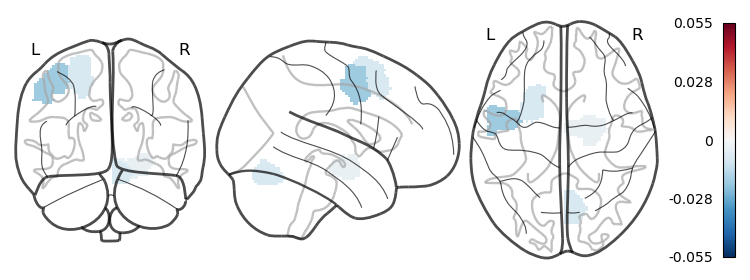

In [20]:
resultspt1 = nib.load("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/isrsa_nn_r_brain_dict_conf_social.ideology.scale.nii")
#view_img(resultspt1)
              
plot_glass_brain(resultspt1, 
                 cmap = 'RdBu_r', 
                 colorbar = True, 
                 #cut_coords = [11,-64,20],
                 vmax = 0.055,
                 symmetric_cbar = True,
                 plot_abs = False)

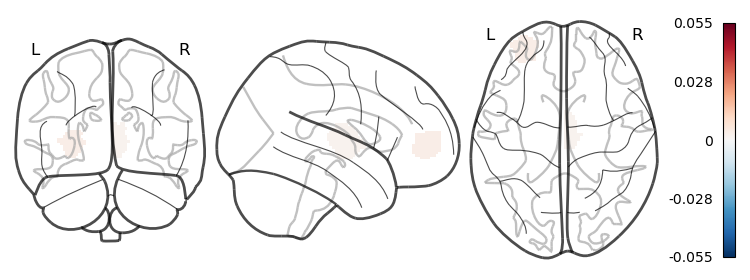

In [28]:
resultspt4 = nib.load("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/isrsa_nn_r_brain_dict_conf_sex.nii")
#view_img(resultspt2)

plot_glass_brain(resultspt4, 
                 cmap = 'RdBu_r', 
                 colorbar = True, 
                 #cut_coords = [8,-14,16],
                 vmax = 0.055,
                 symmetric_cbar = True,
                 plot_abs = False,
                 alpha = 0.7)

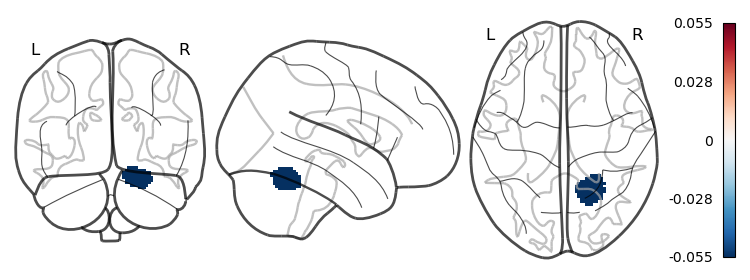

In [30]:
resultspt2 = nib.load("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/isrsa_annak_r_brain_dict_conf_education_level.nii")

plot_glass_brain(resultspt2, 
                 cmap = 'RdBu_r', 
                 colorbar = True, 
                 #cut_coords = [11, -64, -20], 
                 vmax = 0.055, 
                 symmetric_cbar = True,
                 plot_abs = False)

/home/c13572687/anaconda3/envs/isrsa/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


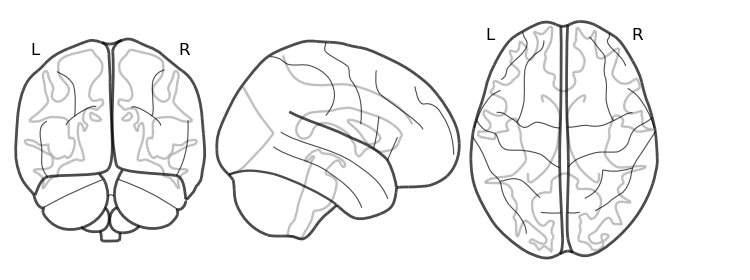

In [39]:
resultspt3 = nib.load("/home/c13572687/Documents/scripts_and_data/nifti_files_analysis/confirmatory/isrsa_annak_r_brain_dict_conf_background_SES.nii")

plot_glass_brain(resultspt3, 
                 cmap = 'RdBu_r', 
                 colorbar = True, 
                 #cut_coords = [-39,-8,43],
                 vmax = 0.055, 
                 symmetric_cbar = True,
                 plot_abs = False,
                 threshold = 0.1)